<a href="https://colab.research.google.com/github/napoles-uach/Ai4sci/blob/main/Stiffness_Hackathon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --pre deepchem

In [ ]:
!pip3 install dgl-cu100

In [ ]:
pip install pymatgen

In [4]:
import deepchem as dc

In [5]:
import os
os.environ['DEEPCHEM_DATA_DIR'] = os.getcwd()

In [6]:
from pymatgen.ext.matproj import MPRester

In [7]:
mpr = MPRester("GVKAlZWLJyoftCu7f")
data2 = mpr.query({'elasticity': {'$exists': True}}, ['material_id', 'elasticity'])

100%|██████████| 13172/13172 [00:14<00:00, 897.19it/s]


In [8]:
mat_id=[] # columna con id
for i in range(len(data2)):#['material_id']
  mat_id.append(data2[i]['material_id'])

In [10]:
def mat2vec(vec):
  i = -1
  stiff_vec = []
  for row in vec:
    i=i+1
    stiff_vec+=row[i:]
  return stiff_vec

In [11]:
import numpy as np

In [37]:
stiff_list = []
struc_list = []
for mat in data2:
  stiffness = mat['elasticity']['elastic_tensor']
  #id = [mat['material_id']]
  stiff_list.append(mat2vec(stiffness))
  id=mat['material_id']
  structure = mpr.get_structure_by_material_id(id)
  struc_list.append(structure)

In [38]:
X = struc_list
y = stiff_list
#dataset = dc.data.NumpyDataset(X, y)

In [39]:
featurizer = dc.feat.CGCNNFeaturizer()
ecfp = featurizer.featurize(struc_list)
ecfp.shape
#(5, 1024)
dataset = dc.data.NumpyDataset(X=ecfp, y=np.array(stiff_list))
len(dataset)

13172

In [40]:
dataset

<NumpyDataset X.shape: (13172,), y.shape: (13172, 21), w.shape: (13172, 1), task_names: [ 0  1  2 ... 18 19 20]>

In [41]:
splitter = dc.splits.RandomSplitter()
train_dataset, valid_dataset, test_dataset = splitter.train_valid_test_split(dataset=dataset, frac_train=0.6, frac_valid=0.2, frac_test=0.2)

In [42]:
model = dc.models.CGCNNModel(mode='regression', batch_size=32, learning_rate=0.001,n_tasks=21)
#model.fit(train_dataset)
model.fit(train_dataset, nb_epoch=50)
#model.fit()

4732.2165625

In [43]:
dc.metrics.mean_absolute_error

<function sklearn.metrics._regression.mean_absolute_error>

In [44]:
metric = dc.metrics.Metric(dc.metrics.mean_absolute_error)#(dc.metrics.mean_squared_error)
print("Training set score:", model.evaluate(train_dataset, [metric]))

Training set score: {'mean_absolute_error': 14.452059789545615}


In [45]:
out=model.predict(valid_dataset)

In [46]:
tru=valid_dataset

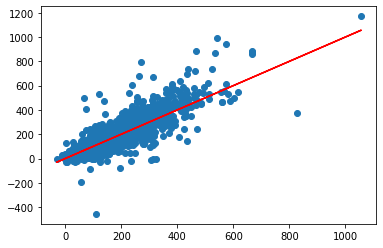

In [66]:
k=0
out_p=[]
for i in out:
  out_p.append(i[k])

out_v=[]
for i in tru.y:
  out_v.append(i[k])

plt.scatter(out_p,out_v)
plt.plot(out_p,out_p,ls='-',c='r')

In [47]:
import matplotlib.pyplot as plt


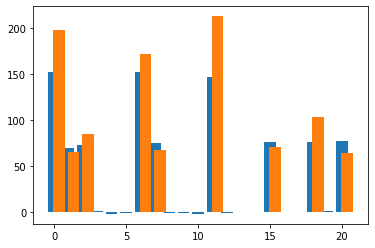

In [75]:
ind = np.arange(21)
width=0.35
i=698
fig, ax = plt.subplots()
b1 = ax.bar(ind, out[i])
b2 = ax.bar(ind+width, tru.y[i])

#ax.set_xticks(ind+width/2)
plt.show()


In [53]:
import seaborn as sns

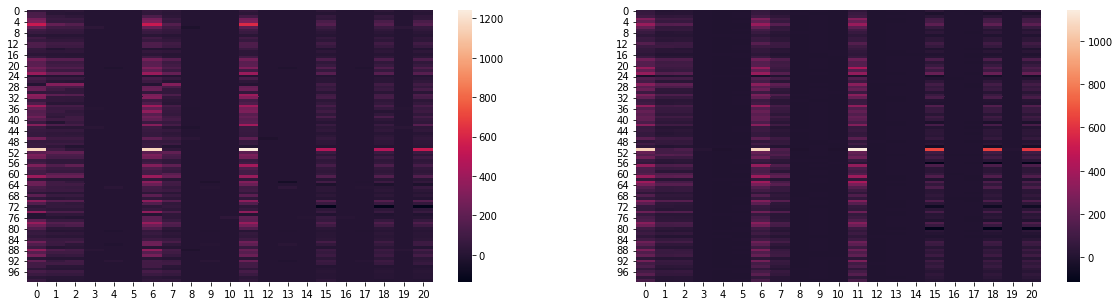

In [61]:
fig, axs = plt.subplots(ncols=2,figsize=(20,5))
sns.heatmap(tru.y[:100],ax=axs[0],)
sns.heatmap(out[:100],ax=axs[1],)